# Dataset #
**Size:**
* 70,000 instances
* 12 features

**Features:**

* Age | Objective Feature | age | int (days)
* Height | Objective Feature | height | int (cm) |
* Weight | Objective Feature | weight | float (kg) |
* Gender | Objective Feature | gender | categorical code |
* Systolic blood pressure | Examination Feature | ap_hi | int |
* Diastolic blood pressure | Examination Feature | ap_lo | int |
* Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
* Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
* Smoking | Subjective Feature | smoke | binary |
* Alcohol intake | Subjective Feature | alco | binary |
* Physical activity | Subjective Feature | active | binary |
* Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

In [1]:
#importing packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cardio_train.csv',delimiter=';')
df.shape

(70000, 13)

In [3]:
df = pd.get_dummies(df,columns=['cholesterol','gluc'])
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3
0,0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0


In [4]:
df.columns.shape

(17,)

In [5]:
# data exploration
print('size: ',df.shape)
print('info:',df.info())
print('null values:',df.isnull().values.any())

size:  (70000, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 17 columns):
id               70000 non-null int64
age              70000 non-null int64
gender           70000 non-null int64
height           70000 non-null int64
weight           70000 non-null float64
ap_hi            70000 non-null int64
ap_lo            70000 non-null int64
smoke            70000 non-null int64
alco             70000 non-null int64
active           70000 non-null int64
cardio           70000 non-null int64
cholesterol_1    70000 non-null uint8
cholesterol_2    70000 non-null uint8
cholesterol_3    70000 non-null uint8
gluc_1           70000 non-null uint8
gluc_2           70000 non-null uint8
gluc_3           70000 non-null uint8
dtypes: float64(1), int64(10), uint8(6)
memory usage: 6.3 MB
info: None
null values: False


In [6]:
# dropping unnecessary columns
df.drop('id',axis=1,inplace=True)

**Identifying outliers**

In [7]:
df[df['ap_lo'] > df['ap_hi']].shape[0]

1234

In [8]:
df[(df['height'] < df['height'].quantile(0.025))].shape

(1537, 16)

In [9]:
df[(df['height'] > df['height'].quantile(0.975))].shape

(1439, 16)

In [10]:
df[(df['ap_hi']>df['ap_hi'].quantile(0.975))].shape

(1114, 16)

* Remove outliers in height, weight that fall below 2.5% and above 97.5%
* Remove outliers, where diastolic pressure is higher than systolic, which is incorrect

In [11]:
# height, weight
df.drop(df[(df['height'] > df['height'].quantile(0.975)) 
           | (df['height'] < df['height'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.975)) 
           | (df['weight'] < df['weight'].quantile(0.025))].index, inplace=True)

In [12]:
# blood pressure
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.975)) 
           | (df['ap_hi'] < df['ap_hi'].quantile(0.025))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.975)) 
           | (df['ap_lo'] < df['ap_lo'].quantile(0.025))].index,inplace=True)

In [13]:
df.shape

(60142, 16)

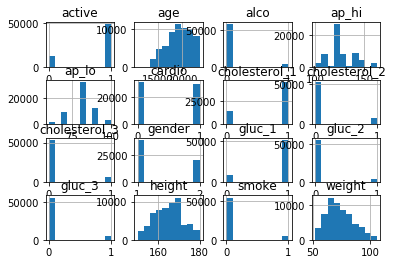

In [14]:
# data contains a lot of binary features
df.hist()
plt.show()

In [15]:
# new feature BMI index
df['bmi'] = df['weight']/((df['height']/100)**2)

In [16]:
df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,bmi
0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,21.967120
1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,34.927679
2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,23.507805


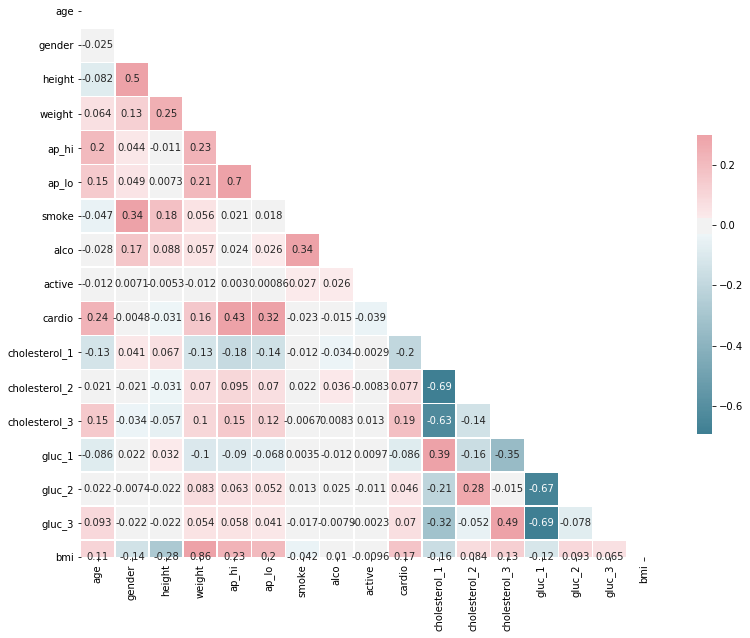

In [17]:
corr = df.corr()
cmap = sns.diverging_palette(220,10,as_cmap=True)
mask = np.zeros_like(corr,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f, ax = plt.subplots(figsize=(13,11))
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=0.3,center=0,annot=True, 
            square=True,linewidth=0.5,cbar_kws={'shrink':0.5});

# plt.savefig('correlation_heatmap.png')

In [18]:
df.head(3)

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,bmi
0,18393,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0,21.967120
1,20228,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0,34.927679
2,18857,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0,23.507805


In [19]:
y = df['cardio']
X = df.drop('cardio',axis=1)

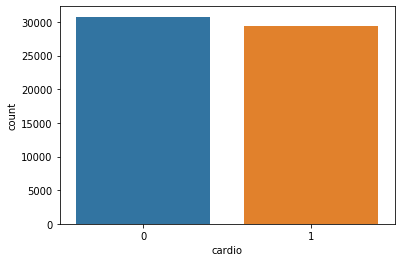

In [20]:
sns.countplot(y)

In [21]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [22]:
X_train.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cholesterol_1,cholesterol_2,cholesterol_3,gluc_1,gluc_2,gluc_3,bmi
24746,19609,2,175,80.0,150,80,0,0,1,1,0,0,1,0,0,26.122449
19479,18387,1,160,70.0,150,90,0,0,1,1,0,0,1,0,0,27.343750
15537,18864,1,155,62.0,140,80,0,0,1,1,0,0,1,0,0,25.806452
39116,14473,2,180,74.0,140,89,0,0,0,1,0,0,1,0,0,22.839506
64308,21191,1,165,95.0,130,90,0,0,0,0,0,1,0,0,1,34.894399


In [23]:
# feature scaling
# scaled only continuous values
ss = StandardScaler()
X_train[['age','height','weight','ap_hi','ap_lo','bmi']] = ss.fit_transform(X_train[['age','height','weight','ap_hi','ap_lo','bmi']])
X_test[['age','height','weight','ap_hi','ap_lo','bmi']] = ss.fit_transform(X_test[['age','height','weight','ap_hi','ap_lo','bmi']])

In [24]:
# logistic regression

logistic = LogisticRegression(random_state=12345)
hyperparameters = {'penalty':('l1','l2'),'C':[1,3]}
clf = GridSearchCV(logistic, hyperparameters, cv=3, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_test)
y_hat_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)

Best Penalty: l1
Best C: 1
Precision 0.6516084873374401
Accuracy 0.7218675179569034
AUC_ROC 0.7247522572825992
[[6094 1637]
 [2545 4760]]


In [25]:
# decision tree 
dt = DecisionTreeClassifier(random_state=12345)
hyperparameters = {'criterion':('entropy','gini'),'min_samples_split':range(2,10,2),'max_depth':range(1,10,2)}
clf = GridSearchCV(dt, hyperparameters, cv=3, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
print('Best Num Split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best Depth:', best_model.best_estimator_.get_params()['max_depth'])

y_pred = best_model.predict(X_test)
y_hat_proba = best_model.predict_proba(X_test)[:,1]

scores = cross_val_score(best_model,X_test,y_pred, cv=5)
cm = confusion_matrix(y_test,y_pred)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print(scores.mean())

Best Citerion: entropy
Best Num Split: 2
Best Depth: 5
Precision 0.6453114305270363
Accuracy 0.7222000532056398
AUC_ROC 0.7258325702075702
[[6145 1586]
 [2591 4714]]
0.999534486021977


In [27]:
# Naive Bayes
nb = GaussianNB()
nb.fit(X_train,y_train)
y_pred = nb.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)

Precision 0.5757700205338809
Accuracy 0.6816307528598031
AUC_ROC 0.687311076595141
[[6043 1688]
 [3099 4206]]


In [28]:
# SVM class_weight = balanced
svm = LinearSVC(dual=False,class_weight='balanced',random_state=12345)
hyperparameters = {'penalty':('l1','l2'),
                   'C':[1,3]}

clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test,y_pred)
scores = cross_val_score(best_model,X_test,y_pred, cv= 5)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(scores.mean())
print(cm)

Best Penalty: l1
Best C: 1
Precision 0.655441478439425
Accuracy 0.7218675179569034
AUC_ROC 0.7243631836212187
0.9986699473393639
[[6066 1665]
 [2517 4788]]


In [29]:
# SVM , class_weight = 1
svm = LinearSVC(dual=False,random_state=12345)
hyperparameters = {'penalty':('l1','l2'),
                   'C':[1,3]}

clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test,y_pred)
scores = cross_val_score(best_model,X_test,y_pred, cv= 5)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(scores.mean())
print(cm)

Best Penalty: l1
Best C: 1
Precision 0.642984257357974
Accuracy 0.7220670391061452
AUC_ROC 0.7259582912161878
0.9987363482255347
[[6160 1571]
 [2608 4697]]


In [30]:
# SVM - SGDClassifier 
svm = SGDClassifier(eta0=1,random_state=12345)
hyperparameters = {'loss':('log','perceptron'),
                   'penalty':('l1','l2','elasticnet'),
                   'learning_rate':('constant','optimal','invscaling','adaptive')}
clf = GridSearchCV(svm, hyperparameters, cv=5, verbose=0)
best_model = clf.fit(X_train, y_train)

print('Best Loss:', best_model.best_estimator_.get_params()['loss'])
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])

y_pred = best_model.predict(X_test)
# y_hat_proba = best_model.predict_proba(X_test)[:,1]

cm = confusion_matrix(y_test,y_pred)
scores = cross_val_score(best_model,X_test,y_pred, cv= 5)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(scores.mean())
print(cm)

Best Loss: log
Best penalty: l1
Best learning_rate: invscaling
Precision 0.6395619438740588
Accuracy 0.7195397712157489
AUC_ROC 0.7234584821350547
0.9986033253967692
[[6147 1584]
 [2633 4672]]


In [33]:
knn = KNeighborsClassifier(metric='minkowski',weights='uniform')
hyperparameters = {'n_neighbors':range(3,10,1), 'p':[1,2]}
clf = GridSearchCV(knn, hyperparameters, cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train, y_train)

print('Best K_value:', best_model.best_estimator_.get_params()['n_neighbors'])
print('Best p:', best_model.best_estimator_.get_params()['p'])

y_pred = best_model.predict(X_test)
y_hat_proba = best_model.predict_proba(X_test)[:,1]

scores = cross_val_score(best_model,X_test,y_pred, cv= 5)
cm = confusion_matrix(y_test,y_pred)
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print(scores.mean())

Best K_value: 9
Best p: 1
Precision 0.6707734428473648
Accuracy 0.7051077414205906
AUC_ROC 0.7052577711911098
[[5702 2029]
 [2405 4900]]
0.8795562297561688


In [35]:
# random forest
rf = RandomForestClassifier()
hyperparameters = {'n_estimators':range(10,20,2), 
                   'criterion':('entropy','gini'),
                   'max_depth':range(1,10,2),
                   'min_samples_split':range(2,10,1)}

clf = GridSearchCV(rf, hyperparameters, cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train, y_train)

print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best min_sample_splits:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

y_pred = best_model.predict(X_test)
y_hat_proba = best_model.predict_proba(X_test)[:,1]

scores = cross_val_score(best_model,X_test,y_pred, cv= 5)
cm = confusion_matrix(y_test,y_pred)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print(scores.mean())

Best Citerion: entropy
Best n_estimator: 18
Best min_sample_splits: 4
Best max_depth: 9
Precision 0.6424366872005476
Accuracy 0.7258579409417398
AUC_ROC 0.7304300649271518
[[6221 1510]
 [2612 4693]]
0.9721342333064367


In [36]:
from sklearn.ensemble import ExtraTreesClassifier

extra_clf = ExtraTreesClassifier()
hyperparameters = {'n_estimators':range(10,20,2), 
                   'criterion':('entropy','gini'),
                   'max_depth':range(1,10,2),
                   'min_samples_split':range(2,10,1)}

clf = GridSearchCV(extra_clf, hyperparameters, cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train, y_train)

print('Best Citerion:', best_model.best_estimator_.get_params()['criterion'])
print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best min_sample_splits:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])

y_pred = best_model.predict(X_test)

cross_val_score(best_model,X_test,y_pred, cv= 5)
cm = confusion_matrix(y_test,y_pred)

print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))
print(cm)
print(scores.mean())

Best Citerion: gini
Best n_estimator: 18
Best min_sample_splits: 3
Best max_depth: 9
Precision 0.6516084873374401
Accuracy 0.7239292364990689
AUC_ROC 0.7270906643968226
[[6125 1606]
 [2545 4760]]
0.9721342333064367


In [40]:
# adaboost
from sklearn.ensemble import AdaBoostClassifier

ada_boost = AdaBoostClassifier(learning_rate=0.99)
hyperparameters = {'n_estimators':range(100,200,10)}
clf = GridSearchCV(ada_boost, hyperparameters, cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train, y_train)

# print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
# print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])


y_pred = best_model.predict(X_test)
cross_val_score(best_model,X_test,y_pred, cv= 5)

print(cm)
print(scores.mean())
print('Precision',precision_score(y_pred,y_test))
print('Accuracy', accuracy_score(y_test,y_pred))
print('AUC_ROC',roc_auc_score(y_pred,y_test))

[[6125 1606]
 [2545 4760]]
0.9721342333064367
Precision 0.6265571526351814
Accuracy 0.7214019686086726
AUC_ROC 0.7274269884861241


In [ ]:
# from sklearn.ensemble import VotingClassifier
# X = X_train
# y = y_train

# vclf = VotingClassifier(estimators=[('lr',logistic_clf),('dt',dt),('nb',nb),('svm',svm),
#                                     ('rf',rf),('knn',knn),('adaboost',ada_boost)],voting='hard')
# for clf, label in zip([logistic_clf,dt,nb,svm,rf,knn,ada_boost],
#                       ['Logistic Regression','Decision Tree','Naive Bayes','SVM',
#                        'Random Forest','KNN','Ada Boost']):
#     scores = cross_val_score(clf,X_train,y_train,cv=7,scoring='accuracy')
#     print('Accuracy: %0.2f(+/- %0.2f)[%s]' % (scores.mean(),scores.std(),label))